In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v2 import Autoencoder
from tools.ESN_v2_AR import ESN as AR_RNN_ESN
from tools.AEESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-02-19 23:29:35.020807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 23:29:35.021304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 23:29:35.066509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 23:29:35.066802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 23:29:35.067121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 23:29:35.069341: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 23:29:35.070253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 23:29:35.070566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 23:29:35.070839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_003'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('data_dir_idx:', data_dir_idx)
print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002
data_dir_idx: 000
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ESN/ESN_003
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_013
24 <class 'int'>


In [12]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [13]:
lyap_time = 1/0.065
delta_t = 1.
T = t_recorded_samples[-1]

In [14]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (100001, 2, 50, 50)


In [15]:
all_data = all_data[0:int(all_data.shape[0]/3)]

In [16]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (33333, 2, 50, 50)


# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50])*dt_rnn/lyap_time
    num_timesteps_warmup = 1*lyap_time/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*lyap_time
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        # 'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [2e-5],
        [1e-5],
        [2e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [50],
        [50],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-7  # weight for regularizer
    covmat_lmda = 1e-3  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 16
    
    train_alpha = [False]*3
    train_omega_in = [False]*3
    train_rho_res = [False]*3
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }

In [22]:
%pdb

Automatic pdb calling has been turned ON




********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


2023-02-19 23:29:41.221349: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


(497, 62, 5000) (497, 5, 5000)


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
25/25 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0117 - global_gradnorm: 3.1337 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 0m 26.4s

Epoch 1: val_NMSE improved from inf to 0.05259, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 26s 569ms/step - loss: 0.0309 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0116 - global_gradnorm: 3.

25/25 [==============================] - ETA: 0s - loss: 0.0194 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0083 - global_gradnorm: 1.9002 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 5.3s

Epoch 9: val_NMSE did not improve from 0.04328
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 489ms/step - loss: 0.0194 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0083 - global_gradnorm: 1.9052 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0512 - val_mse: 0.0049 - val_NMSE: 0.0443 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
25/25 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0088 - global_gradnorm: 2.0325 - rho_

Epoch 19/1000
25/25 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0012 - NMSE: 0.0106 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.7311 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 4m 8.8s

Epoch 19: val_NMSE did not improve from 0.04289
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 491ms/step - loss: 0.0192 - mse: 0.0012 - NMSE: 0.0106 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.7396 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0536 - val_mse: 0.0052 - val_NMSE: 0.0468 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
25/25 [==============================] - ETA: 0s - loss: 0.0184 - mse: 0.0011 - NMSE: 0.0098 - covmat_fro_loss: 0.0079 - global_gradnorm

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 521ms/step - loss: 0.0174 - mse: 9.6102e-04 - NMSE: 0.0087 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.4165 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0488 - val_mse: 0.0046 - val_NMSE: 0.0417 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 29/1000
25/25 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0010 - NMSE: 0.0095 - covmat_fro_loss: 0.0077 - global_gradnorm: 1.4576 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 6m 13.8s

Epoch 29: val_NMSE did not improve from 0.04172
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_

Epoch 38/1000
25/25 [==============================] - ETA: 0s - loss: 0.0175 - mse: 9.6994e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0075 - global_gradnorm: 1.3349 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 8m 5.2s

Epoch 38: val_NMSE improved from 0.04158 to 0.04090, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 521ms/step - loss: 0.0175 - mse: 9.6994e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.3344 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0480 - val_mse: 0.0045 - val_NMSE: 0.0409 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 39

Epoch 48/1000
25/25 [==============================] - ETA: 0s - loss: 0.0172 - mse: 9.3205e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.2293 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 10m 8.2s

Epoch 48: val_NMSE improved from 0.04090 to 0.04072, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 508ms/step - loss: 0.0172 - mse: 9.3205e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.2334 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0478 - val_mse: 0.0045 - val_NMSE: 0.0407 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 4

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 13s 505ms/step - loss: 0.0172 - mse: 9.3817e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.1703 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0475 - val_mse: 0.0044 - val_NMSE: 0.0404 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 58/1000
25/25 [==============================] - ETA: 0s - loss: 0.0172 - mse: 9.3570e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.0958 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 12m 9.8s

Epoch 58: val_NMSE did not improve from 0.04040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoin

Epoch 67/1000
25/25 [==============================] - ETA: 0s - loss: 0.0173 - mse: 9.4919e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0072 - global_gradnorm: 1.2169 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 13m 59.0s

Epoch 67: val_NMSE did not improve from 0.04040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 491ms/step - loss: 0.0173 - mse: 9.4919e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0072 - global_gradnorm: 1.2131 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0508 - val_mse: 0.0048 - val_NMSE: 0.0438 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 68/1000
25/25 [==============================] - ETA: 0s - loss: 0.0165 - mse: 8.6113e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0070 - g

Epoch 77/1000
25/25 [==============================] - ETA: 0s - loss: 0.0175 - mse: 9.7530e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0073 - global_gradnorm: 1.1422 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 16m 1.9s

Epoch 77: val_NMSE did not improve from 0.04026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 490ms/step - loss: 0.0175 - mse: 9.7530e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0073 - global_gradnorm: 1.1444 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0483 - val_mse: 0.0045 - val_NMSE: 0.0412 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 78/1000
25/25 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0074 - global

Epoch 87/1000
25/25 [==============================] - ETA: 0s - loss: 0.0168 - mse: 8.9356e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0070 - global_gradnorm: 1.0875 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 18m 3.9s

Epoch 87: val_NMSE did not improve from 0.04026
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 493ms/step - loss: 0.0168 - mse: 8.9356e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0070 - global_gradnorm: 1.0977 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0480 - val_mse: 0.0045 - val_NMSE: 0.0409 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 88/1000
25/25 [==============================] - ETA: 0s - loss: 0.0171 - mse: 9.3150e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0072 - gl

Epoch 97/1000
25/25 [==============================] - ETA: 0s - loss: 0.0173 - mse: 9.4761e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0072 - global_gradnorm: 1.1909 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 20m 5.7s

Epoch 97: val_NMSE did not improve from 0.04000
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 493ms/step - loss: 0.0173 - mse: 9.4761e-04 - NMSE: 0.0086 - covmat_fro_loss: 0.0072 - global_gradnorm: 1.1885 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0472 - val_mse: 0.0044 - val_NMSE: 0.0400 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 98/1000
25/25 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0074 - global

Epoch 107/1000
25/25 [==============================] - ETA: 0s - loss: 0.0170 - mse: 9.1971e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.0940 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 22m 8.8s

Epoch 107: val_NMSE did not improve from 0.03954
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 496ms/step - loss: 0.0170 - mse: 9.1971e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.0980 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0469 - val_mse: 0.0044 - val_NMSE: 0.0398 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 108/1000
25/25 [==============================] - ETA: 0s - loss: 0.0171 - mse: 9.3149e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0071 -

Epoch 117/1000
25/25 [==============================] - ETA: 0s - loss: 0.0171 - mse: 9.2390e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0070 - global_gradnorm: 1.0418 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 24m 9.3s

Epoch 117: val_NMSE did not improve from 0.03954
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 484ms/step - loss: 0.0171 - mse: 9.2390e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0070 - global_gradnorm: 1.0401 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0468 - val_mse: 0.0044 - val_NMSE: 0.0397 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 118/1000
25/25 [==============================] - ETA: 0s - loss: 0.0171 - mse: 9.2748e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0072 -

25/25 [==============================] - ETA: 0s - loss: 0.0171 - mse: 9.2855e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0070 - global_gradnorm: 1.0298 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 26m 0.1s

Epoch 126: val_NMSE did not improve from 0.03914
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 490ms/step - loss: 0.0171 - mse: 9.2855e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0070 - global_gradnorm: 1.0258 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0473 - val_mse: 0.0044 - val_NMSE: 0.0402 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 127/1000
25/25 [==============================] - ETA: 0s - loss: 0.0164 - mse: 8.4624e-04 - NMSE: 0.0077 - covmat_fro_loss: 0.0068 - global_gradnor

Epoch 136/1000
25/25 [==============================] - ETA: 0s - loss: 0.0173 - mse: 9.4536e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0070 - global_gradnorm: 1.0045 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 28m 2.4s

Epoch 136: val_NMSE did not improve from 0.03914
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 493ms/step - loss: 0.0173 - mse: 9.4536e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0070 - global_gradnorm: 0.9990 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0467 - val_mse: 0.0044 - val_NMSE: 0.0395 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 137/1000
25/25 [==============================] - ETA: 0s - loss: 0.0163 - mse: 8.3618e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0068 -

Epoch 146/1000
25/25 [==============================] - ETA: 0s - loss: 0.0169 - mse: 9.0136e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0069 - global_gradnorm: 1.0131 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 30m 4.3s

Epoch 146: val_NMSE did not improve from 0.03914
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 487ms/step - loss: 0.0169 - mse: 9.0136e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0068 - global_gradnorm: 1.0089 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0469 - val_mse: 0.0044 - val_NMSE: 0.0398 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 147/1000
25/25 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0073 - glo

Epoch 156/1000
25/25 [==============================] - ETA: 0s - loss: 0.0172 - mse: 9.3457e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0070 - global_gradnorm: 0.9289 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 32m 5.9s

Epoch 156: val_NMSE did not improve from 0.03884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 496ms/step - loss: 0.0172 - mse: 9.3457e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0069 - global_gradnorm: 0.9225 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0467 - val_mse: 0.0044 - val_NMSE: 0.0396 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 157/1000
25/25 [==============================] - ETA: 0s - loss: 0.0160 - mse: 7.9900e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0066 -

Epoch 166/1000
25/25 [==============================] - ETA: 0s - loss: 0.0161 - mse: 8.0784e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0066 - global_gradnorm: 0.9166 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 34m 8.4s

Epoch 166: val_NMSE did not improve from 0.03884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 492ms/step - loss: 0.0161 - mse: 8.0784e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0066 - global_gradnorm: 0.9133 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0465 - val_mse: 0.0043 - val_NMSE: 0.0394 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 167/1000
25/25 [==============================] - ETA: 0s - loss: 0.0157 - mse: 7.6602e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0066 -

Epoch 176/1000
25/25 [==============================] - ETA: 0s - loss: 0.0164 - mse: 8.4437e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0068 - global_gradnorm: 0.9649 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 36m 2.8s

Epoch 176: val_NMSE did not improve from 0.03884
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 445ms/step - loss: 0.0164 - mse: 8.4437e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0068 - global_gradnorm: 0.9625 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0464 - val_mse: 0.0043 - val_NMSE: 0.0392 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 177/1000
25/25 [==============================] - ETA: 0s - loss: 0.0154 - mse: 7.3180e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0063 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 484ms/step - loss: 0.0159 - mse: 7.8702e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0066 - global_gradnorm: 0.8311 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0457 - val_mse: 0.0042 - val_NMSE: 0.0385 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 186/1000
25/25 [==============================] - ETA: 0s - loss: 0.0161 - mse: 8.1184e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0066 - global_gradnorm: 0.8766 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 37m 56.1s

Epoch 186: val_NMSE did not improve from 0.03853
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckp

Epoch 195/1000
25/25 [==============================] - ETA: 0s - loss: 0.0158 - mse: 7.7846e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0066 - global_gradnorm: 0.8616 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 39m 36.9s

Epoch 195: val_NMSE did not improve from 0.03853
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 444ms/step - loss: 0.0158 - mse: 7.7846e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0066 - global_gradnorm: 0.8593 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0462 - val_mse: 0.0043 - val_NMSE: 0.0390 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 196/1000
25/25 [==============================] - ETA: 0s - loss: 0.0177 - mse: 9.9599e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0071 

Epoch 205/1000
25/25 [==============================] - ETA: 0s - loss: 0.0177 - mse: 9.9537e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0069 - global_gradnorm: 0.8379 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 41m 29.7s

Epoch 205: val_NMSE improved from 0.03853 to 0.03845, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 493ms/step - loss: 0.0177 - mse: 9.9537e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0068 - global_gradnorm: 0.8323 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0457 - val_mse: 0.0042 - val_NMSE: 0.0385 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoc

25/25 [==============================] - ETA: 0s - loss: 0.0157 - mse: 7.6277e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0063 - global_gradnorm: 0.8010 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 43m 18.2s

Epoch 214: val_NMSE did not improve from 0.03842
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 481ms/step - loss: 0.0157 - mse: 7.6277e-04 - NMSE: 0.0069 - covmat_fro_loss: 0.0063 - global_gradnorm: 0.8025 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0466 - val_mse: 0.0043 - val_NMSE: 0.0394 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 215/1000
25/25 [==============================] - ETA: 0s - loss: 0.0165 - mse: 8.5826e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0068 - global_gradno

Epoch 224/1000
25/25 [==============================] - ETA: 0s - loss: 0.0161 - mse: 8.0888e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0066 - global_gradnorm: 0.8230 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 45m 15.2s

Epoch 224: val_NMSE did not improve from 0.03820
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 435ms/step - loss: 0.0161 - mse: 8.0888e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0066 - global_gradnorm: 0.8233 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0460 - val_mse: 0.0043 - val_NMSE: 0.0388 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 225/1000
25/25 [==============================] - ETA: 0s - loss: 0.0165 - mse: 8.5810e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0068 

Epoch 234/1000
25/25 [==============================] - ETA: 0s - loss: 0.0153 - mse: 7.2367e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0063 - global_gradnorm: 0.7922 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 47m 11.0s

Epoch 234: val_NMSE did not improve from 0.03766
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 445ms/step - loss: 0.0153 - mse: 7.2367e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0063 - global_gradnorm: 0.7853 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0455 - val_mse: 0.0042 - val_NMSE: 0.0383 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 235/1000
25/25 [==============================] - ETA: 0s - loss: 0.0157 - mse: 7.6938e-04 - NMSE: 0.0070 - covmat_fro_loss: 0.0065 

Epoch 244/1000
25/25 [==============================] - ETA: 0s - loss: 0.0154 - mse: 7.2786e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0064 - global_gradnorm: 0.7786 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 49m 6.7s

Epoch 244: val_NMSE did not improve from 0.03766
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 466ms/step - loss: 0.0154 - mse: 7.2786e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0065 - global_gradnorm: 0.7744 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0451 - val_mse: 0.0042 - val_NMSE: 0.0378 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 245/1000
25/25 [==============================] - ETA: 0s - loss: 0.0154 - mse: 7.3422e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0063 -

Epoch 254/1000
25/25 [==============================] - ETA: 0s - loss: 0.0159 - mse: 7.8635e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0065 - global_gradnorm: 0.7534 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 51m 3.8s

Epoch 254: val_NMSE did not improve from 0.03766
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 12s 475ms/step - loss: 0.0159 - mse: 7.8635e-04 - NMSE: 0.0071 - covmat_fro_loss: 0.0065 - global_gradnorm: 0.7542 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0473 - val_mse: 0.0044 - val_NMSE: 0.0402 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 255/1000
25/25 [==============================] - ETA: 0s - loss: 0.0168 - mse: 8.9550e-04 - NMSE: 0.0081 - covmat_fro_loss: 0.0068 -

Epoch 264/1000
25/25 [==============================] - ETA: 0s - loss: 0.0166 - mse: 8.6331e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0067 - global_gradnorm: 0.7870 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 52m 56.0s

Epoch 264: val_NMSE did not improve from 0.03766
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 433ms/step - loss: 0.0166 - mse: 8.6331e-04 - NMSE: 0.0078 - covmat_fro_loss: 0.0067 - global_gradnorm: 0.7855 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0465 - val_mse: 0.0043 - val_NMSE: 0.0394 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 265/1000
25/25 [==============================] - ETA: 0s - loss: 0.0159 - mse: 7.9221e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0065 

Epoch 274/1000
25/25 [==============================] - ETA: 0s - loss: 0.0172 - mse: 9.3816e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0068 - global_gradnorm: 0.8223 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 54m 44.1s

Epoch 274: val_NMSE did not improve from 0.03766
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 11s 437ms/step - loss: 0.0172 - mse: 9.3816e-04 - NMSE: 0.0085 - covmat_fro_loss: 0.0069 - global_gradnorm: 0.8276 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0452 - val_mse: 0.0042 - val_NMSE: 0.0380 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 275/1000
25/25 [==============================] - ETA: 0s - loss: 0.0164 - mse: 8.4580e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0066 

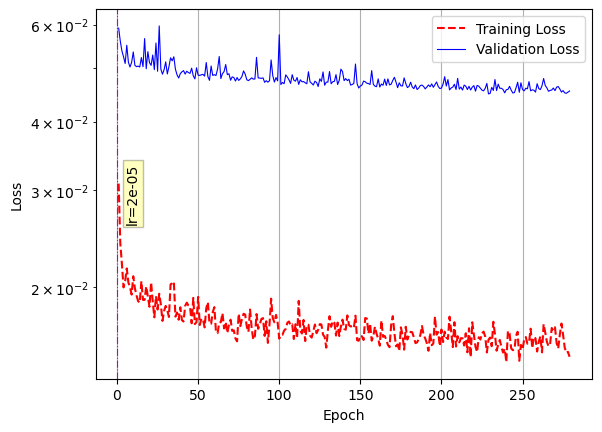

<Figure size 640x480 with 0 Axes>

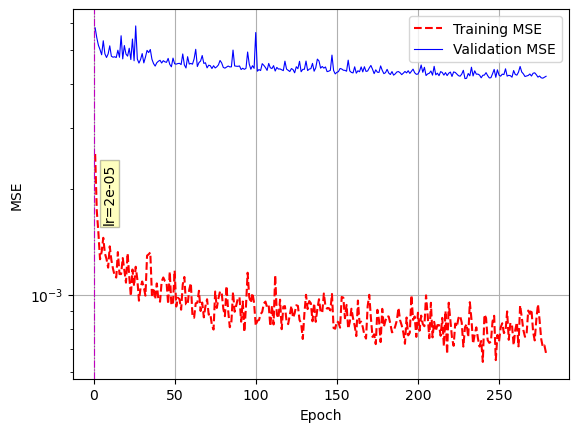

<Figure size 640x480 with 0 Axes>

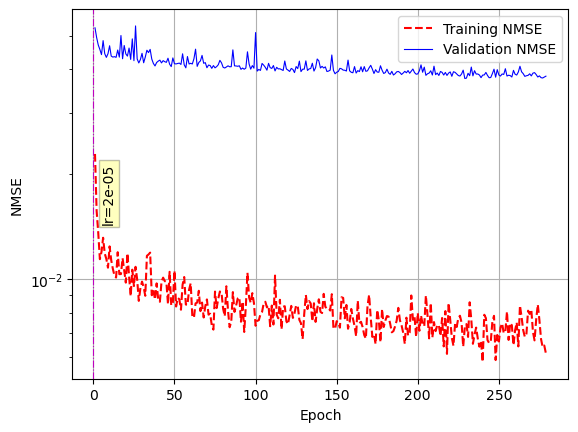

<Figure size 640x480 with 0 Axes>

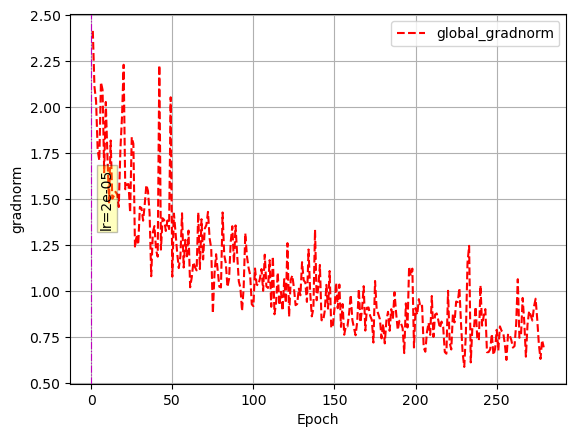

<Figure size 640x480 with 0 Axes>

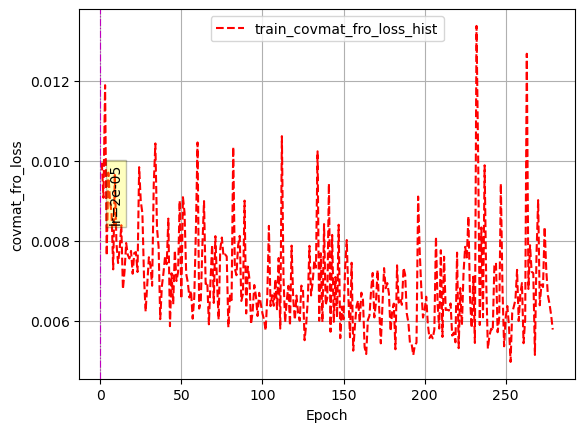



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 2.25
(462, 62, 5000) (462, 10, 5000)


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
22/22 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0026 - NMSE: 0.0239 - covmat_fro_loss: 0.0105 - global_gradnorm: 2.1951 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 0m 41.3s

Epoch 1: val_NMSE improved from inf to 0.04978, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-10_outsteps
 - saving lo

22/22 [==============================] - ETA: 0s - loss: 0.0208 - mse: 0.0014 - NMSE: 0.0131 - covmat_fro_loss: 0.0084 - global_gradnorm: 1.5998 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 24.0s

Epoch 9: val_NMSE did not improve from 0.04817
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 566ms/step - loss: 0.0208 - mse: 0.0014 - NMSE: 0.0131 - covmat_fro_loss: 0.0084 - global_gradnorm: 1.6108 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0521 - val_mse: 0.0053 - val_NMSE: 0.0482 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
22/22 [==============================] - ETA: 0s - loss: 0.0204 - mse: 0.0014 - NMSE: 0.0126 - covmat_fro_loss: 0.0082 - global_gradnorm: 1.5747 - rh

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 14s 616ms/step - loss: 0.0206 - mse: 0.0014 - NMSE: 0.0128 - covmat_fro_loss: 0.0083 - global_gradnorm: 1.5417 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0518 - val_mse: 0.0053 - val_NMSE: 0.0478 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 19/1000
22/22 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0015 - NMSE: 0.0137 - covmat_fro_loss: 0.0084 - global_gradnorm: 1.6763 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 4m 34.2s

Epoch 19: val_NMSE did not improve from 0.04783
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_ou

Epoch 28/1000
22/22 [==============================] - ETA: 0s - loss: 0.0191 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0078 - global_gradnorm: 1.5210 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 6m 31.2s

Epoch 28: val_NMSE did not improve from 0.04741
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 578ms/step - loss: 0.0191 - mse: 0.0012 - NMSE: 0.0111 - covmat_fro_loss: 0.0077 - global_gradnorm: 1.5249 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0519 - val_mse: 0.0053 - val_NMSE: 0.0479 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 29/1000
22/22 [==============================] - ETA: 0s - loss: 0.0187 - mse: 0.0012 - NMSE: 0.0107 - covmat_fro_loss: 0.0077 - global_gradno

Epoch 37/1000
22/22 [==============================] - ETA: 0s - loss: 0.0190 - mse: 0.0012 - NMSE: 0.0110 - covmat_fro_loss: 0.0078 - global_gradnorm: 1.5272 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 8m 27.5s

Epoch 37: val_NMSE did not improve from 0.04614
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 559ms/step - loss: 0.0190 - mse: 0.0012 - NMSE: 0.0110 - covmat_fro_loss: 0.0077 - global_gradnorm: 1.5222 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0508 - val_mse: 0.0052 - val_NMSE: 0.0467 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 38/1000
22/22 [==============================] - ETA: 0s - loss: 0.0189 - mse: 0.0012 - NMSE: 0.0109 - covmat_fro_loss: 0.0076 - global_gradno

Epoch 47/1000
22/22 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.3664 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 10m 22.4s

Epoch 47: val_NMSE did not improve from 0.04614
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 542ms/step - loss: 0.0178 - mse: 0.0011 - NMSE: 0.0097 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.3568 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0517 - val_mse: 0.0053 - val_NMSE: 0.0478 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 48/1000
22/22 [==============================] - ETA: 0s - loss: 0.0172 - mse: 9.8950e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0073 - global_g

Epoch 57/1000
22/22 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0012 - NMSE: 0.0112 - covmat_fro_loss: 0.0078 - global_gradnorm: 1.5321 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 12m 18.8s

Epoch 57: val_NMSE did not improve from 0.04614
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 543ms/step - loss: 0.0192 - mse: 0.0012 - NMSE: 0.0112 - covmat_fro_loss: 0.0078 - global_gradnorm: 1.5354 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0523 - val_mse: 0.0053 - val_NMSE: 0.0483 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 58/1000
22/22 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0012 - NMSE: 0.0112 - covmat_fro_loss: 0.0079 - global_gradn

Epoch 67/1000
22/22 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.5453 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 14m 27.1s

Epoch 67: val_NMSE did not improve from 0.04614
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 591ms/step - loss: 0.0180 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.5752 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0511 - val_mse: 0.0052 - val_NMSE: 0.0470 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 68/1000
22/22 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0071 - global_gradn

22/22 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.4996 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 16m 26.0s

Epoch 76: val_NMSE did not improve from 0.04577
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 606ms/step - loss: 0.0181 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.5038 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0506 - val_mse: 0.0051 - val_NMSE: 0.0464 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 77/1000
22/22 [==============================] - ETA: 0s - loss: 0.0187 - mse: 0.0012 - NMSE: 0.0107 - covmat_fro_loss: 0.0075 - global_gradnorm: 1.4541 - 

Epoch 86/1000
22/22 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0075 - global_gradnorm: 1.6563 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 18m 34.6s

Epoch 86: val_NMSE did not improve from 0.04577
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 577ms/step - loss: 0.0181 - mse: 0.0011 - NMSE: 0.0100 - covmat_fro_loss: 0.0074 - global_gradnorm: 1.6473 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0510 - val_mse: 0.0052 - val_NMSE: 0.0469 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 87/1000
22/22 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0010 - NMSE: 0.0095 - covmat_fro_loss: 0.0073 - global_gradn

Epoch 96/1000
22/22 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0072 - global_gradnorm: 1.5587 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 20m 43.5s

Epoch 96: val_NMSE did not improve from 0.04544
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 590ms/step - loss: 0.0176 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0072 - global_gradnorm: 1.5635 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0527 - val_mse: 0.0054 - val_NMSE: 0.0488 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 97/1000
22/22 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0012 - NMSE: 0.0105 - covmat_fro_loss: 0.0075 - global_gradn

Epoch 106/1000
22/22 [==============================] - ETA: 0s - loss: 0.0175 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0072 - global_gradnorm: 1.4549 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 22m 48.8s

Epoch 106: val_NMSE did not improve from 0.04544
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 573ms/step - loss: 0.0175 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.4494 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0513 - val_mse: 0.0052 - val_NMSE: 0.0473 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 107/1000
22/22 [==============================] - ETA: 0s - loss: 0.0171 - mse: 9.8636e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0071 - globa

Epoch 116/1000
22/22 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.3898 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000  - tot_time: 0h 24m 46.6s

Epoch 116: val_NMSE did not improve from 0.04482
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 11s 505ms/step - loss: 0.0173 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0070 - global_gradnorm: 1.3790 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0502 - val_mse: 0.0051 - val_NMSE: 0.0459 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 117/1000
22/22 [==============================] - ETA: 0s - loss: 0.0184 - mse: 0.0011 - NMSE: 0.0104 - covmat_fro_loss: 0.0073 - global_g

Epoch 126/1000
22/22 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.4164 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 26m 43.9s

Epoch 126: val_NMSE did not improve from 0.04458
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 537ms/step - loss: 0.0173 - mse: 0.0010 - NMSE: 0.0091 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.4082 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0503 - val_mse: 0.0051 - val_NMSE: 0.0462 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 127/1000
22/22 [==============================] - ETA: 0s - loss: 0.0171 - mse: 9.8920e-04 - NMSE: 0.0089 - covmat_fro_loss: 0.0071 - globa

Epoch 136/1000
22/22 [==============================] - ETA: 0s - loss: 0.0170 - mse: 9.7264e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0069 - global_gradnorm: 1.3116 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 28m 43.3s

Epoch 136: val_NMSE did not improve from 0.04458
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 564ms/step - loss: 0.0170 - mse: 9.7264e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0068 - global_gradnorm: 1.3102 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0500 - val_mse: 0.0051 - val_NMSE: 0.0458 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 137/1000
22/22 [==============================] - ETA: 0s - loss: 0.0177 - mse: 0.0010 - NMSE: 0.0095 - covmat_fro_loss: 0.0072 - g

Epoch 146/1000
22/22 [==============================] - ETA: 0s - loss: 0.0172 - mse: 9.9184e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0069 - global_gradnorm: 1.3770 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 30m 48.7s

Epoch 146: val_NMSE did not improve from 0.04458
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 588ms/step - loss: 0.0172 - mse: 9.9184e-04 - NMSE: 0.0090 - covmat_fro_loss: 0.0069 - global_gradnorm: 1.3837 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0508 - val_mse: 0.0052 - val_NMSE: 0.0467 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 147/1000
22/22 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0010 - NMSE: 0.0092 - covmat_fro_loss: 0.0070 - g

Epoch 156/1000
22/22 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0073 - global_gradnorm: 1.7349 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 32m 57.7s

Epoch 156: val_NMSE did not improve from 0.04458
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 577ms/step - loss: 0.0176 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0073 - global_gradnorm: 1.7357 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0512 - val_mse: 0.0052 - val_NMSE: 0.0471 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 157/1000
22/22 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0073 - global_gr

Epoch 166/1000
22/22 [==============================] - ETA: 0s - loss: 0.0167 - mse: 9.3012e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0068 - global_gradnorm: 1.2477 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 35m 5.5s

Epoch 166: val_NMSE did not improve from 0.04435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 597ms/step - loss: 0.0167 - mse: 9.3012e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0068 - global_gradnorm: 1.2439 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0490 - val_mse: 0.0049 - val_NMSE: 0.0447 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 167/1000
22/22 [==============================] - ETA: 0s - loss: 0.0167 - mse: 9.3267e-04 - NMSE: 0.0084 - covmat_fro_loss: 0.0067 

Epoch 176/1000
22/22 [==============================] - ETA: 0s - loss: 0.0166 - mse: 9.1491e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0068 - global_gradnorm: 1.4918 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 37m 2.0s

Epoch 176: val_NMSE did not improve from 0.04435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 12s 548ms/step - loss: 0.0166 - mse: 9.1491e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0068 - global_gradnorm: 1.5113 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0495 - val_mse: 0.0050 - val_NMSE: 0.0452 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 177/1000
22/22 [==============================] - ETA: 0s - loss: 0.0171 - mse: 9.7670e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0069 

Epoch 186/1000
22/22 [==============================] - ETA: 0s - loss: 0.0177 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.4113 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 38m 58.6s

Epoch 186: val_NMSE did not improve from 0.04435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 11s 519ms/step - loss: 0.0177 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 0.0071 - global_gradnorm: 1.4130 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0490 - val_mse: 0.0049 - val_NMSE: 0.0447 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 187/1000
22/22 [==============================] - ETA: 0s - loss: 0.0190 - mse: 0.0012 - NMSE: 0.0110 - covmat_fro_loss: 0.0075 - global_gr

Epoch 196/1000
22/22 [==============================] - ETA: 0s - loss: 0.0160 - mse: 8.4140e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0065 - global_gradnorm: 1.3510 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 41m 4.4s

Epoch 196: val_NMSE did not improve from 0.04435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 576ms/step - loss: 0.0160 - mse: 8.4140e-04 - NMSE: 0.0076 - covmat_fro_loss: 0.0065 - global_gradnorm: 1.3404 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0494 - val_mse: 0.0050 - val_NMSE: 0.0451 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 197/1000
22/22 [==============================] - ETA: 0s - loss: 0.0175 - mse: 0.0010 - NMSE: 0.0094 - covmat_fro_loss: 0.0070 - gl

Epoch 206/1000
22/22 [==============================] - ETA: 0s - loss: 0.0170 - mse: 9.6890e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0069 - global_gradnorm: 1.4099 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 43m 10.8s

Epoch 206: val_NMSE did not improve from 0.04435
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 13s 573ms/step - loss: 0.0170 - mse: 9.6890e-04 - NMSE: 0.0088 - covmat_fro_loss: 0.0069 - global_gradnorm: 1.4117 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0504 - val_mse: 0.0051 - val_NMSE: 0.0463 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 207/1000
22/22 [==============================] - ETA: 0s - loss: 0.0165 - mse: 9.1206e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0067

Epoch 215: early stopping


<Figure size 640x480 with 0 Axes>

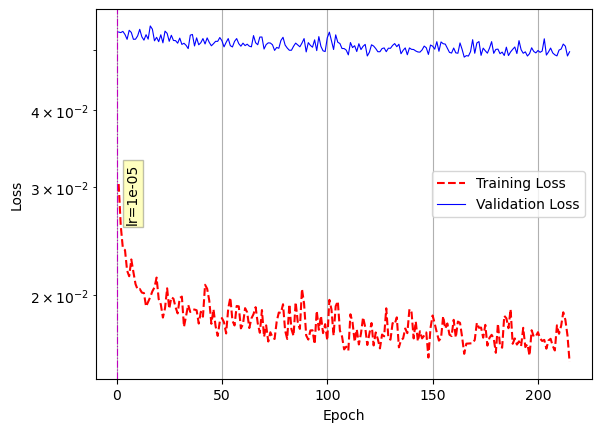

<Figure size 640x480 with 0 Axes>

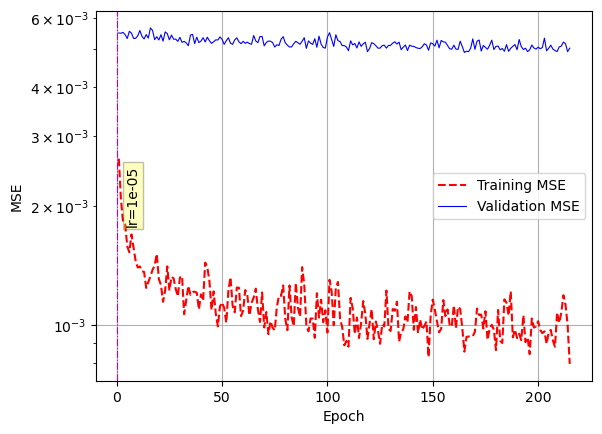

<Figure size 640x480 with 0 Axes>

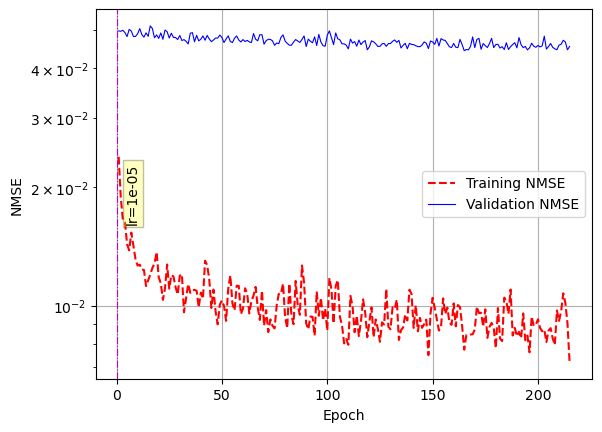

<Figure size 640x480 with 0 Axes>

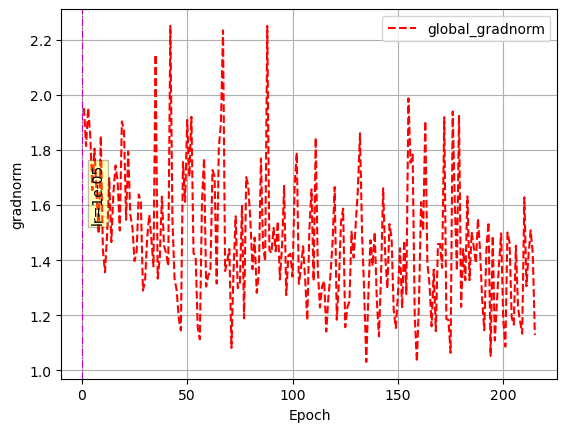

<Figure size 640x480 with 0 Axes>

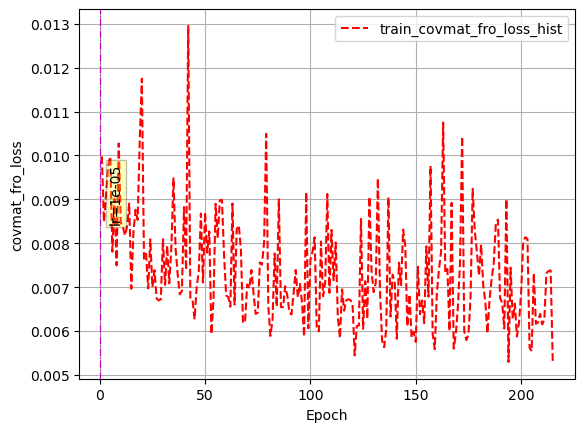



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 2.025
(362, 62, 5000) (362, 30, 5000)


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
18/18 [==============================] - ETA: 0s - loss: 0.0529 - mse: 0.0073 - NMSE: 0.0659 - covmat_fro_loss: 0.0114 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 1m 31.4s

Epoch 1: val_NMSE improved from inf to 0.16901, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-30_outsteps
 - saving l

Epoch 10/1000
18/18 [==============================] - ETA: 0s - loss: 0.0382 - mse: 0.0047 - NMSE: 0.0428 - covmat_fro_loss: 0.0104 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 3m 56.2s

Epoch 10: val_NMSE did not improve from 0.16798
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 16s 914ms/step - loss: 0.0382 - mse: 0.0047 - NMSE: 0.0428 - covmat_fro_loss: 0.0104 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1280 - val_mse: 0.0189 - val_NMSE: 0.1715 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 11/1000
18/18 [==============================] - ETA: 0s - loss: 0.0356 - mse: 0.0043 - NMSE: 0.0390 - covmat_fro_loss: 0.0100 - global_gradno

18/18 [==============================] - ETA: 0s - loss: 0.0311 - mse: 0.0035 - NMSE: 0.0320 - covmat_fro_loss: 0.0094 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 6m 28.8s

Epoch 19: val_NMSE did not improve from 0.16559
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 17s 966ms/step - loss: 0.0311 - mse: 0.0035 - NMSE: 0.0320 - covmat_fro_loss: 0.0095 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1304 - val_mse: 0.0194 - val_NMSE: 0.1755 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
18/18 [==============================] - ETA: 0s - loss: 0.0325 - mse: 0.0038 - NMSE: 0.0340 - covmat_fro_loss: 0.0097 - global_gradnorm: 2.0250 - r

Epoch 29/1000
18/18 [==============================] - ETA: 0s - loss: 0.0300 - mse: 0.0034 - NMSE: 0.0305 - covmat_fro_loss: 0.0093 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 9m 17.8s

Epoch 29: val_NMSE did not improve from 0.16559
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 17s 930ms/step - loss: 0.0300 - mse: 0.0034 - NMSE: 0.0305 - covmat_fro_loss: 0.0092 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1273 - val_mse: 0.0189 - val_NMSE: 0.1710 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 30/1000
18/18 [==============================] - ETA: 0s - loss: 0.0335 - mse: 0.0039 - NMSE: 0.0357 - covmat_fro_loss: 0.0098 - global_gradno

Epoch 39/1000
18/18 [==============================] - ETA: 0s - loss: 0.0308 - mse: 0.0035 - NMSE: 0.0315 - covmat_fro_loss: 0.0094 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 12m 0.4s

Epoch 39: val_NMSE did not improve from 0.16222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 17s 931ms/step - loss: 0.0308 - mse: 0.0035 - NMSE: 0.0315 - covmat_fro_loss: 0.0096 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1259 - val_mse: 0.0186 - val_NMSE: 0.1688 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 40/1000
18/18 [==============================] - ETA: 0s - loss: 0.0330 - mse: 0.0039 - NMSE: 0.0349 - covmat_fro_loss: 0.0099 - global_gradno

Epoch 49/1000
18/18 [==============================] - ETA: 0s - loss: 0.0351 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0101 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 14m 41.6s

Epoch 49: val_NMSE did not improve from 0.15683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 16s 906ms/step - loss: 0.0351 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0102 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1239 - val_mse: 0.0183 - val_NMSE: 0.1659 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 50/1000
18/18 [==============================] - ETA: 0s - loss: 0.0308 - mse: 0.0035 - NMSE: 0.0315 - covmat_fro_loss: 0.0094 - global_gradn

Epoch 59/1000
18/18 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0035 - NMSE: 0.0320 - covmat_fro_loss: 0.0095 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 17m 26.3s

Epoch 59: val_NMSE did not improve from 0.15683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 987ms/step - loss: 0.0312 - mse: 0.0035 - NMSE: 0.0320 - covmat_fro_loss: 0.0094 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1276 - val_mse: 0.0190 - val_NMSE: 0.1716 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 60/1000
18/18 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0032 - NMSE: 0.0289 - covmat_fro_loss: 0.0092 - global_gradn

Epoch 69/1000
18/18 [==============================] - ETA: 0s - loss: 0.0326 - mse: 0.0038 - NMSE: 0.0343 - covmat_fro_loss: 0.0097 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 20m 16.1s

Epoch 69: val_NMSE did not improve from 0.15683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 16s 917ms/step - loss: 0.0326 - mse: 0.0038 - NMSE: 0.0343 - covmat_fro_loss: 0.0096 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1263 - val_mse: 0.0187 - val_NMSE: 0.1694 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 70/1000
18/18 [==============================] - ETA: 0s - loss: 0.0283 - mse: 0.0031 - NMSE: 0.0279 - covmat_fro_loss: 0.0090 - global_gradn

Epoch 79/1000
18/18 [==============================] - ETA: 0s - loss: 0.0282 - mse: 0.0030 - NMSE: 0.0275 - covmat_fro_loss: 0.0090 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 23m 4.4s

Epoch 79: val_NMSE did not improve from 0.15683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 16s 908ms/step - loss: 0.0282 - mse: 0.0030 - NMSE: 0.0275 - covmat_fro_loss: 0.0090 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1283 - val_mse: 0.0191 - val_NMSE: 0.1728 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 80/1000
18/18 [==============================] - ETA: 0s - loss: 0.0303 - mse: 0.0034 - NMSE: 0.0305 - covmat_fro_loss: 0.0093 - global_gradno

Epoch 89/1000
18/18 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0036 - NMSE: 0.0325 - covmat_fro_loss: 0.0095 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 25m 54.3s

Epoch 89: val_NMSE did not improve from 0.15515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 979ms/step - loss: 0.0314 - mse: 0.0036 - NMSE: 0.0325 - covmat_fro_loss: 0.0096 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1243 - val_mse: 0.0184 - val_NMSE: 0.1665 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 90/1000
18/18 [==============================] - ETA: 0s - loss: 0.0291 - mse: 0.0032 - NMSE: 0.0291 - covmat_fro_loss: 0.0091 - global_gradn

Epoch 99/1000
18/18 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0032 - NMSE: 0.0293 - covmat_fro_loss: 0.0092 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 28m 45.3s

Epoch 99: val_NMSE did not improve from 0.15515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 978ms/step - loss: 0.0293 - mse: 0.0032 - NMSE: 0.0293 - covmat_fro_loss: 0.0092 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1266 - val_mse: 0.0188 - val_NMSE: 0.1699 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 100/1000
18/18 [==============================] - ETA: 0s - loss: 0.0284 - mse: 0.0031 - NMSE: 0.0279 - covmat_fro_loss: 0.0090 - global_grad

Epoch 109/1000
18/18 [==============================] - ETA: 0s - loss: 0.0266 - mse: 0.0028 - NMSE: 0.0254 - covmat_fro_loss: 0.0086 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 31m 41.6s

Epoch 109: val_NMSE did not improve from 0.15515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 1s/step - loss: 0.0266 - mse: 0.0028 - NMSE: 0.0254 - covmat_fro_loss: 0.0086 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1296 - val_mse: 0.0193 - val_NMSE: 0.1746 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 110/1000
18/18 [==============================] - ETA: 0s - loss: 0.0283 - mse: 0.0031 - NMSE: 0.0281 - covmat_fro_loss: 0.0089 - global_gradn

Epoch 119/1000
18/18 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0034 - NMSE: 0.0306 - covmat_fro_loss: 0.0092 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 34m 29.2s

Epoch 119: val_NMSE did not improve from 0.15515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 18s 988ms/step - loss: 0.0301 - mse: 0.0034 - NMSE: 0.0306 - covmat_fro_loss: 0.0091 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1236 - val_mse: 0.0182 - val_NMSE: 0.1653 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 120/1000
18/18 [==============================] - ETA: 0s - loss: 0.0274 - mse: 0.0029 - NMSE: 0.0266 - covmat_fro_loss: 0.0088 - global_gr

Epoch 129/1000
18/18 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0028 - NMSE: 0.0258 - covmat_fro_loss: 0.0087 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 37m 22.3s

Epoch 129: val_NMSE did not improve from 0.15515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 17s 959ms/step - loss: 0.0270 - mse: 0.0028 - NMSE: 0.0258 - covmat_fro_loss: 0.0088 - global_gradnorm: 2.0250 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1238 - val_mse: 0.0183 - val_NMSE: 0.1657 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 130/1000
18/18 [==============================] - ETA: 0s - loss: 0.0273 - mse: 0.0029 - NMSE: 0.0264 - covmat_fro_loss: 0.0087 - global_gr

<Figure size 640x480 with 0 Axes>

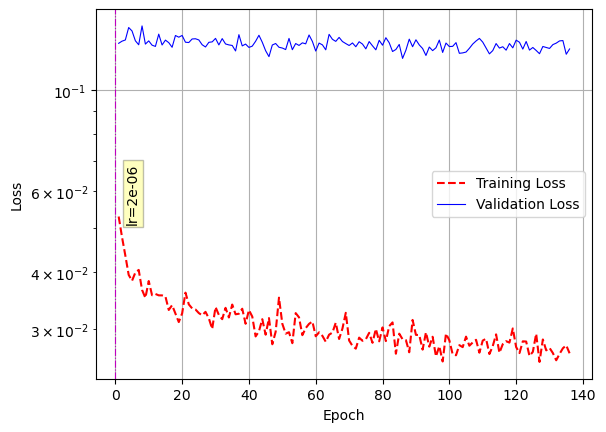

<Figure size 640x480 with 0 Axes>

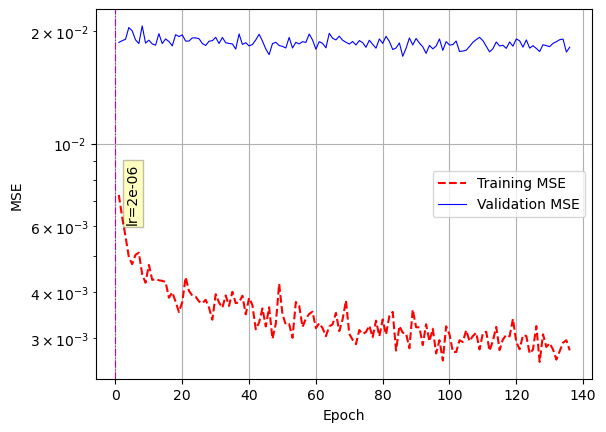

<Figure size 640x480 with 0 Axes>

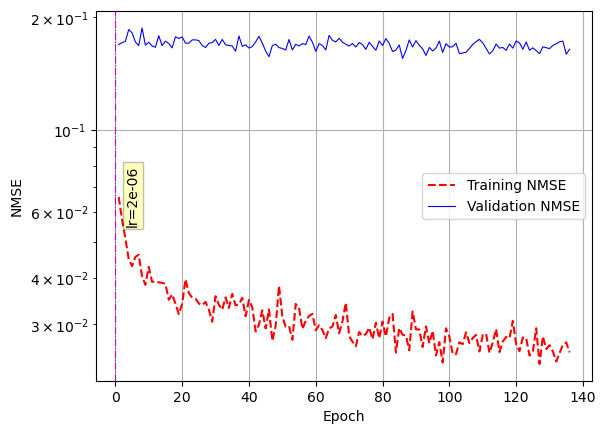

<Figure size 640x480 with 0 Axes>

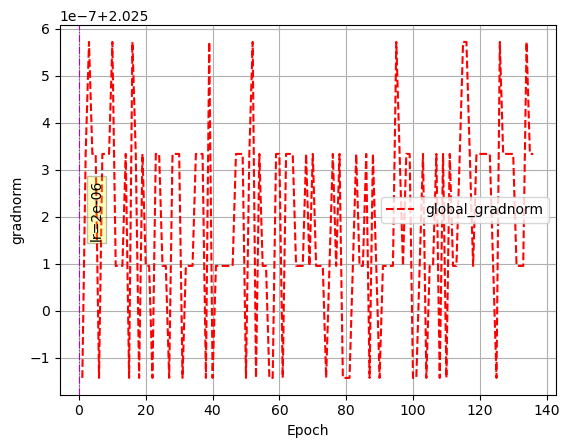

<Figure size 640x480 with 0 Axes>

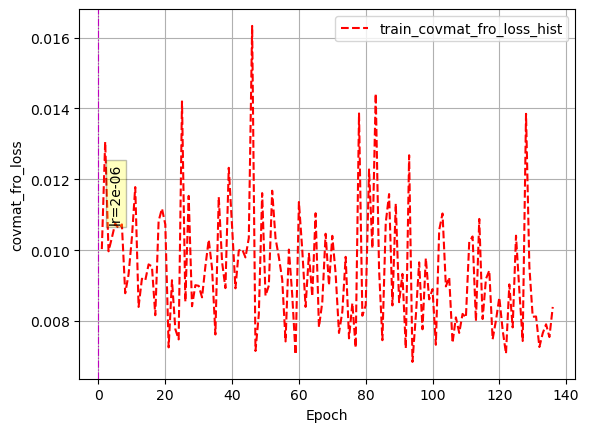



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 1.8
(297, 62, 5000) (297, 50, 5000)


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
14/14 [==============================] - ETA: 0s - loss: 0.0754 - mse: 0.0148 - NMSE: 0.1340 - covmat_fro_loss: 0.0115 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 24.3s

Epoch 1: val_NMSE improved from inf to 0.20939, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-50_outsteps
 - saving los

14/14 [==============================] - ETA: 0s - loss: 0.0519 - mse: 0.0094 - NMSE: 0.0847 - covmat_fro_loss: 0.0104 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 5m 0.7s

Epoch 9: val_NMSE did not improve from 0.18630
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 19s 1s/step - loss: 0.0519 - mse: 0.0094 - NMSE: 0.0847 - covmat_fro_loss: 0.0104 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1115 - val_mse: 0.0217 - val_NMSE: 0.1963 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
14/14 [==============================] - ETA: 0s - loss: 0.0476 - mse: 0.0083 - NMSE: 0.0756 - covmat_fro_loss: 0.0100 - global_gradnorm: 1.8000 - rho_re

Epoch 19/1000
14/14 [==============================] - ETA: 0s - loss: 0.0499 - mse: 0.0089 - NMSE: 0.0804 - covmat_fro_loss: 0.0102 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 8m 11.6s

Epoch 19: val_NMSE did not improve from 0.18630
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 19s 1s/step - loss: 0.0499 - mse: 0.0089 - NMSE: 0.0804 - covmat_fro_loss: 0.0103 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1105 - val_mse: 0.0214 - val_NMSE: 0.1942 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
14/14 [==============================] - ETA: 0s - loss: 0.0448 - mse: 0.0077 - NMSE: 0.0700 - covmat_fro_loss: 0.0099 - global_gradnorm:

Epoch 29/1000
14/14 [==============================] - ETA: 0s - loss: 0.0468 - mse: 0.0082 - NMSE: 0.0743 - covmat_fro_loss: 0.0101 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 11m 15.3s

Epoch 29: val_NMSE did not improve from 0.18461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 17s 1s/step - loss: 0.0468 - mse: 0.0082 - NMSE: 0.0743 - covmat_fro_loss: 0.0101 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1108 - val_mse: 0.0216 - val_NMSE: 0.1955 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 30/1000
14/14 [==============================] - ETA: 0s - loss: 0.0430 - mse: 0.0074 - NMSE: 0.0666 - covmat_fro_loss: 0.0096 - global_gradnorm

Epoch 39/1000
14/14 [==============================] - ETA: 0s - loss: 0.0421 - mse: 0.0071 - NMSE: 0.0645 - covmat_fro_loss: 0.0095 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 14m 17.7s

Epoch 39: val_NMSE did not improve from 0.18461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 18s 1s/step - loss: 0.0421 - mse: 0.0071 - NMSE: 0.0645 - covmat_fro_loss: 0.0094 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1088 - val_mse: 0.0210 - val_NMSE: 0.1901 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 40/1000
14/14 [==============================] - ETA: 0s - loss: 0.0395 - mse: 0.0066 - NMSE: 0.0596 - covmat_fro_loss: 0.0093 - global_gradnorm

Epoch 49/1000
14/14 [==============================] - ETA: 0s - loss: 0.0413 - mse: 0.0069 - NMSE: 0.0628 - covmat_fro_loss: 0.0096 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 17m 22.5s

Epoch 49: val_NMSE did not improve from 0.18452
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 17s 1s/step - loss: 0.0413 - mse: 0.0069 - NMSE: 0.0628 - covmat_fro_loss: 0.0096 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1085 - val_mse: 0.0210 - val_NMSE: 0.1904 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 50/1000
14/14 [==============================] - ETA: 0s - loss: 0.0445 - mse: 0.0076 - NMSE: 0.0688 - covmat_fro_loss: 0.0098 - global_gradnorm

Epoch 59/1000
14/14 [==============================] - ETA: 0s - loss: 0.0407 - mse: 0.0067 - NMSE: 0.0611 - covmat_fro_loss: 0.0097 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 20m 24.7s

Epoch 59: val_NMSE did not improve from 0.18452
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 19s 1s/step - loss: 0.0407 - mse: 0.0067 - NMSE: 0.0611 - covmat_fro_loss: 0.0096 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1120 - val_mse: 0.0217 - val_NMSE: 0.1968 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 60/1000
14/14 [==============================] - ETA: 0s - loss: 0.0442 - mse: 0.0076 - NMSE: 0.0684 - covmat_fro_loss: 0.0098 - global_gradnorm

Epoch 69/1000
14/14 [==============================] - ETA: 0s - loss: 0.0408 - mse: 0.0068 - NMSE: 0.0618 - covmat_fro_loss: 0.0094 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 23m 25.5s

Epoch 69: val_NMSE did not improve from 0.18452
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 18s 1s/step - loss: 0.0408 - mse: 0.0068 - NMSE: 0.0618 - covmat_fro_loss: 0.0093 - global_gradnorm: 1.8000 - rho_res_0: 0.8000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1130 - val_mse: 0.0220 - val_NMSE: 0.1996 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.8000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 70/1000
14/14 [==============================] - ETA: 0s - loss: 0.0393 - mse: 0.0065 - NMSE: 0.0589 - covmat_fro_loss: 0.0093 - global_gradnorm

<Figure size 640x480 with 0 Axes>

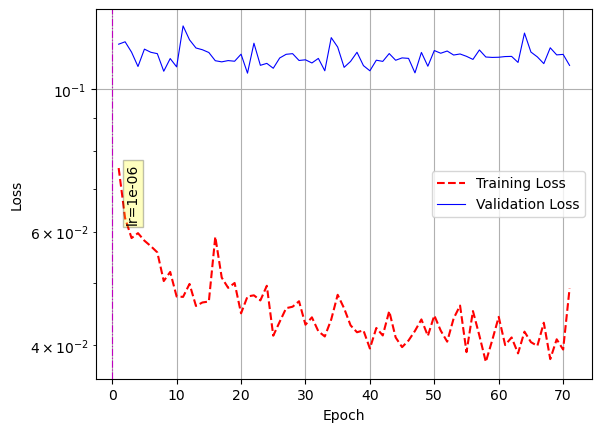

<Figure size 640x480 with 0 Axes>

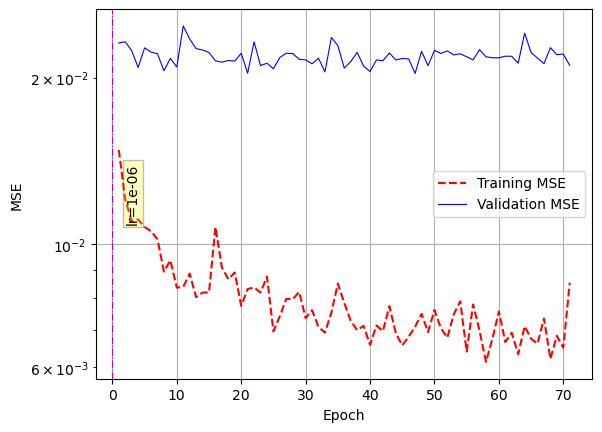

<Figure size 640x480 with 0 Axes>

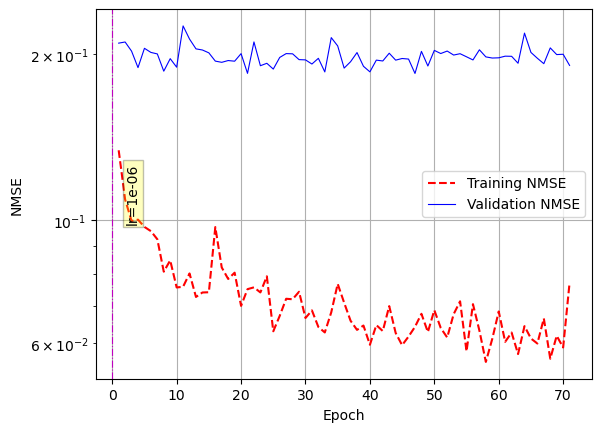

<Figure size 640x480 with 0 Axes>

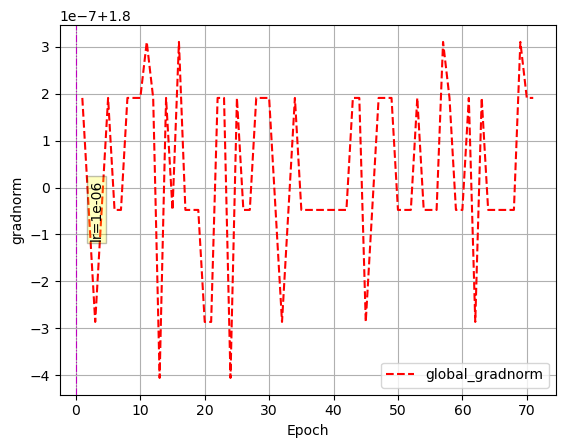

<Figure size 640x480 with 0 Axes>

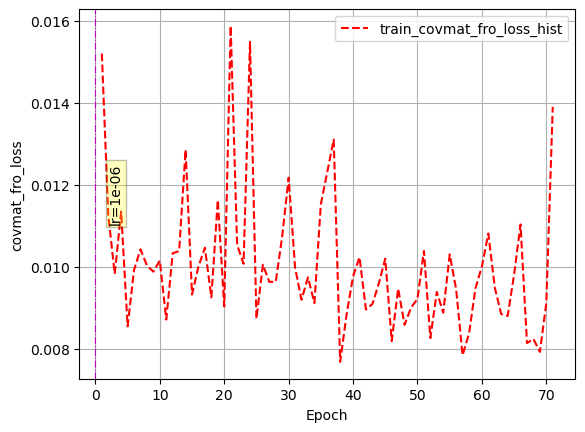

<Figure size 640x480 with 0 Axes>

In [23]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=[all_data.shape[0]],# boundary_idx_arr,
        delta_t=dt_rnn,#delta_t,
        # params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.9 * 0.25 * np.round(4*global_clipnorm)

In [24]:
batch_size*np.round(int(all_data.shape[0]*0.8)/batch_size)

26672.0

In [25]:
### Training the combined AE-RNN
# %pdb

In [26]:
normalization_constant_arr_aedata.shape

(2, 2, 50, 50)

# 